In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from transformers import pipeline
from wordcloud import WordCloud
from datasets import get_dataset_config_names, load_dataset


In [2]:
text = "I absolutely loved this series! The storytelling was engaging, the characters were well-developed, and the cinematography was stunning. Each episode kept me hooked, and I couldn't stop binge-watching. Highly recommended!"

classifier = pipeline('text-classification')

text_class = classifier(text)

pd.DataFrame(text_class)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cuda:0


,label,score
0,POSITIVE,0.999885


In [3]:
dataset_names = get_dataset_config_names("glue")
print(dataset_names)

['ax', 'cola', 'mnli', 'mnli_matched', 'mnli_mismatched', 'mrpc', 'qnli', 'qqp', 'rte', 'sst2', 'stsb', 'wnli']


In [4]:
emotions = load_dataset('emotion')  # Example: Load sentiment dataset
print(emotions)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})


In [5]:
train_ds = emotions['train']
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [6]:
label_names = emotions['train'].features['label'].names
label_names

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

In [7]:
print(len(train_ds))

print(train_ds[0])
print(train_ds.column_names)

16000
{'text': 'i didnt feel humiliated', 'label': 0}
['text', 'label']


In [8]:
train = pd.DataFrame(train_ds)
train.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [11]:
emotions.set_format(type='pandas')

df = emotions['train'][:]
display(df.tail())

def label_int2str(row):
    return emotions['train'].features['label'].int2str(row)

df['label_name'] = df['label'].apply(label_int2str)

display(df.head())

,text,label
15995,i just had a very brief time in the beanbag an...,0
15996,i am now turning and i feel pathetic that i am...,0
15997,i feel strong and good overall,1
15998,i feel like this was such a rude comment and i...,3
15999,i know a lot but i feel so stupid because i ca...,0


,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


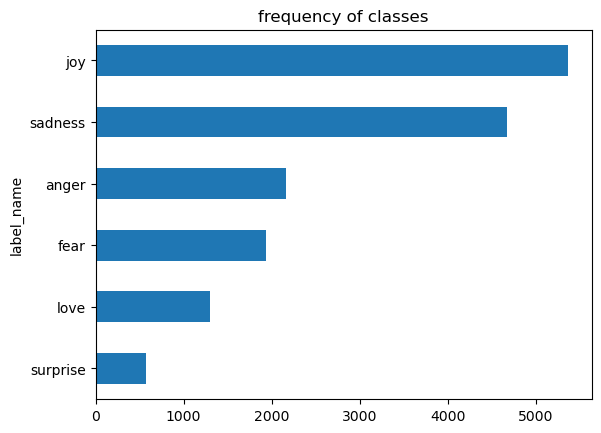

In [12]:
df['label_name'].value_counts(ascending=True).plot.barh()
plt.title('frequency of classes')
plt.show()

## plotly visualization from the emotion train DF

In [13]:
train['length_of_text'] = [len(i.split(' ')) for i in train['text']]
plt.figure(figsize=(10, 10))

fig = px.histogram(train['length_of_text'], marginal='box', labels={'value':'lenght_of_the_text'})

fig.update_traces(marker=dict(line=dict(color='#000000', width=2)))

fig.update_layout(title_text='distribution length of text by emotion', title_x=0.5, title_font=dict(size=20))

fig.show()

<Figure size 1000x1000 with 0 Axes>

In [14]:
plt.figure(figsize=(10, 10))
fig = px.histogram(train['length_of_text'], marginal='box', labels={'value':'lenght_of_the_text'}, color=train['label'])

fig.update_traces(marker=dict(line=dict(color='#000000', width=2)))

fig.update_layout(title_text='distribution length of text by emotion', title_x=0.5, title_font=dict(size=20))

fig.show()

<Figure size 1000x1000 with 0 Axes>

## Distributions of label

In [15]:
fig = px.histogram(train, x='label', color='label')
fig.update_traces(marker=dict(line=dict(color='#000000', width=2)))

fig.update_layout(title_text='dist of labels', title_x=0.5, title_font=dict(size=20))

fig.show()

## frequency of words in train datasets

In [16]:
freq_of_words = train['text'].str.split(expand=True).stack().value_counts()

freq_of_words_top200 = freq_of_words[:200]
freq_of_words_top200.index

Index(['i', 'feel', 'and', 'to', 'the', 'a', 'feeling', 'that', 'of', 'my',
       ...
       'few', 'year', 'thought', 'first', 'times', 'family', 'started', 'able',
       'said', 'week'],
      dtype='object', length=200)

In [17]:
fig = px.treemap(freq_of_words_top200, path=[freq_of_words_top200.index], values='count')

fig.update_layout(title_text='freq of the words in train datasets', title_x=0.5, title_font=dict(size=20))

fig.update_traces(textinfo='label+value')

fig.show()

## text preprocessing

In [19]:
def tokenization(inputs):
    return word_tokenize(inputs)

train['text_tokenized'] = train['text'].apply(tokenization)

train.head()

,text,label,length_of_text,text_tokenized
0,i didnt feel humiliated,0,4,"[i, didnt, feel, humiliated]"
1,i can go from feeling so hopeless to so damned...,0,21,"[i, can, go, from, feeling, so, hopeless, to, ..."
2,im grabbing a minute to post i feel greedy wrong,3,10,"[im, grabbing, a, minute, to, post, i, feel, g..."
3,i am ever feeling nostalgic about the fireplac...,2,18,"[i, am, ever, feeling, nostalgic, about, the, ..."
4,i am feeling grouchy,3,4,"[i, am, feeling, grouchy]"


## stopword removal

In [22]:
stop_word = set(stopwords.words('english'))
def stopwords_remove(inputs):
    return [item for item in inputs if item not in stop_word]

train['text_after_removing_stopwords'] = train['text_tokenized'].apply(stopwords_remove)

train.head()

,text,label,length_of_text,text_tokenized,text_after_removing_stopwords
0,i didnt feel humiliated,0,4,"[i, didnt, feel, humiliated]","[didnt, feel, humiliated]"
1,i can go from feeling so hopeless to so damned...,0,21,"[i, can, go, from, feeling, so, hopeless, to, ...","[go, feeling, hopeless, damned, hopeful, aroun..."
2,im grabbing a minute to post i feel greedy wrong,3,10,"[im, grabbing, a, minute, to, post, i, feel, g...","[im, grabbing, minute, post, feel, greedy, wrong]"
3,i am ever feeling nostalgic about the fireplac...,2,18,"[i, am, ever, feeling, nostalgic, about, the, ...","[ever, feeling, nostalgic, fireplace, know, st..."
4,i am feeling grouchy,3,4,"[i, am, feeling, grouchy]","[feeling, grouchy]"


## Lamitization

In [23]:
lemmatizer = WordNetLemmatizer()

def lemmatization(inputs):
    return [lemmatizer.lemmatize(word=x, pos='v') for x in inputs]

train['text_lemmatized'] = train['text_after_removing_stopwords'].apply(lemmatization)

train.head()


,text,label,length_of_text,text_tokenized,text_after_removing_stopwords,text_lemmatized
0,i didnt feel humiliated,0,4,"[i, didnt, feel, humiliated]","[didnt, feel, humiliated]","[didnt, feel, humiliate]"
1,i can go from feeling so hopeless to so damned...,0,21,"[i, can, go, from, feeling, so, hopeless, to, ...","[go, feeling, hopeless, damned, hopeful, aroun...","[go, feel, hopeless, damn, hopeful, around, so..."
2,im grabbing a minute to post i feel greedy wrong,3,10,"[im, grabbing, a, minute, to, post, i, feel, g...","[im, grabbing, minute, post, feel, greedy, wrong]","[im, grab, minute, post, feel, greedy, wrong]"
3,i am ever feeling nostalgic about the fireplac...,2,18,"[i, am, ever, feeling, nostalgic, about, the, ...","[ever, feeling, nostalgic, fireplace, know, st...","[ever, feel, nostalgic, fireplace, know, still..."
4,i am feeling grouchy,3,4,"[i, am, feeling, grouchy]","[feeling, grouchy]","[feel, grouchy]"


## joining token into sentence

In [24]:
train['text_cleaned'] = train['text_lemmatized'].str.join(' ')
train.head()

,text,label,length_of_text,text_tokenized,text_after_removing_stopwords,text_lemmatized,text_cleaned
0,i didnt feel humiliated,0,4,"[i, didnt, feel, humiliated]","[didnt, feel, humiliated]","[didnt, feel, humiliate]",didnt feel humiliate
1,i can go from feeling so hopeless to so damned...,0,21,"[i, can, go, from, feeling, so, hopeless, to, ...","[go, feeling, hopeless, damned, hopeful, aroun...","[go, feel, hopeless, damn, hopeful, around, so...",go feel hopeless damn hopeful around someone c...
2,im grabbing a minute to post i feel greedy wrong,3,10,"[im, grabbing, a, minute, to, post, i, feel, g...","[im, grabbing, minute, post, feel, greedy, wrong]","[im, grab, minute, post, feel, greedy, wrong]",im grab minute post feel greedy wrong
3,i am ever feeling nostalgic about the fireplac...,2,18,"[i, am, ever, feeling, nostalgic, about, the, ...","[ever, feeling, nostalgic, fireplace, know, st...","[ever, feel, nostalgic, fireplace, know, still...",ever feel nostalgic fireplace know still property
4,i am feeling grouchy,3,4,"[i, am, feeling, grouchy]","[feeling, grouchy]","[feel, grouchy]",feel grouchy


## Word cloud

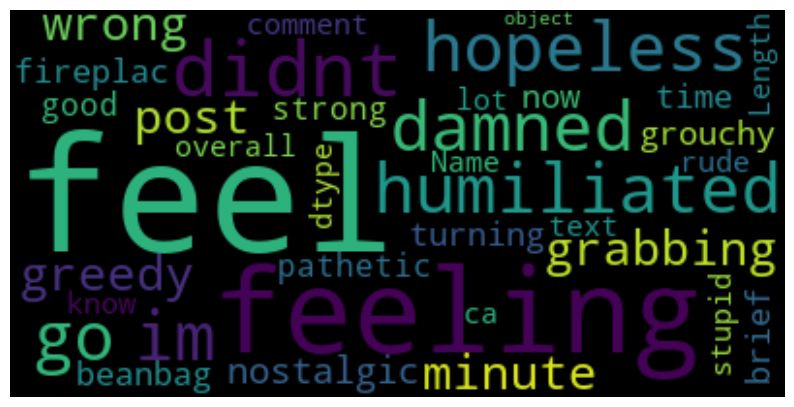

In [28]:
wordcloud = WordCloud(max_words=150, random_state=30, collocations=True).generate(str(train['text']))
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [29]:
freq_of_words = train['text_cleaned'].str.split(expand=True).stack().value_counts()

freq_of_words_top200 = freq_of_words[:200]
freq_of_words_top200.index

fig = px.treemap(freq_of_words_top200, path=[freq_of_words_top200.index], values='count')

fig.update_layout(title_text='freq of the words in train datasets', title_x=0.5, title_font=dict(size=20))

fig.update_traces(textinfo='label+value')

fig.show()